In [1]:
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DAY = "day_1" # 24.07

In [3]:
def get_dataframe(f_name, save_xlsx=False):
    with open(f"raw_data/{f_name}.bmerawdata") as f:
        j = json.load(f)
    column_names = [el["name"] for el in j["rawDataBody"]["dataColumns"]]
    df = pd.DataFrame(j["rawDataBody"]["dataBlock"], columns=column_names)

    if save_xlsx:
        df.to_excel(f"raw_data/{f_name}.xlsx")

    return df

In [4]:
def build_sensor_data(df):
    df["Date"] = pd.to_datetime(
        df["Real time clock"],
        unit="s",
        utc=True).map(lambda x: x.tz_convert("Europe/Istanbul"))
    df["Date"] = df["Date"].dt.tz_localize(None)

    sensor_indexes = sorted(df["Sensor Index"].unique())

    sensors = {}
    for i in sensor_indexes:
        sensors[i] = {}
        sensor = df[df["Sensor Index"] == i]
        heater_indexes = sorted(sensor["Heater Profile Step Index"].unique())
        for j in heater_indexes:
            sensors[i][j] = sensor[sensor["Heater Profile Step Index"] == j]

    return sensors

In [5]:
def build_raw_data_pickle(save_pickle=None):
    sensor_data = {}
    for matrix in ["air", "sample"]:
        df = get_dataframe(f"{DAY}/{matrix}")
        sensor_data[f"{matrix}"] = build_sensor_data(df)

    if save_pickle is not None:
        with open(f"{save_pickle}.pkl", "wb") as f:
            pickle.dump(sensor_data, f)

    return sensor_data

In [6]:
# sensor_data = build_raw_data_pickle(save_pickle=f"data/{DAY}/raw")
sensor_data = build_raw_data_pickle()

In [27]:
def plot_sensor(matrix, sensor_idx, sensor_data, save_as=None):
    plt.figure(figsize=(6, 4))
    plt.title(f"{matrix.capitalize()} Matrix, Sensor {sensor_idx}")
    plt.yscale("log")
    plt.ylabel("Resistance (Ω)")
    plt.xlabel("Timestamp")
    for hp_idx, val in sensor_data[f"{matrix}"][sensor_idx].items():
        resistance = val["Resistance Gassensor"].values
        time_ms = val["Time Since PowerOn"].values
        plt.plot(time_ms, resistance, label=f"HP {hp_idx}")
    plt.legend()
    plt.tight_layout()
    if save_as is not None:
        plt.savefig(save_as)

    plt.show()

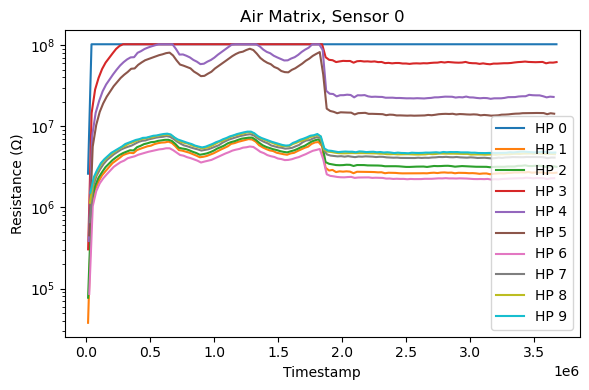

In [28]:
plot_sensor("air", 0, sensor_data)

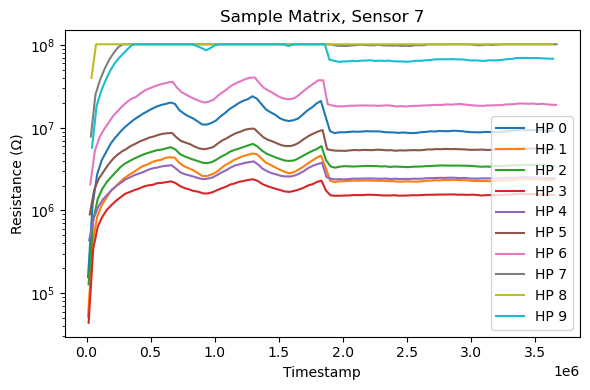

In [29]:
plot_sensor("sample", 7, sensor_data, save_as="sensor_7.pdf")